# Stage 10b: Time Series & Classification
Sparsh Patel 08/25/2025

In [2]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data 
We start by importing our data

In [3]:
import os
os.chdir('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework10B')
print(os.getcwd())

/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework10B


In [ ]:

df = pd.read_csv('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework10B/data/project10_timeseries.csv', parse_dates=['Date'], index_col='Date')
df

,price,ret,log_ret
Date,,,
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589
...,...,...,...
2022-11-25,54.778078,0.010816,0.010758
2022-11-28,55.716059,0.017123,0.016978
2022-11-29,55.574235,-0.002545,-0.002549


## Option B: Synthetic Generator (Use if you don't have data ready)

In [9]:
# # Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()



## Feature Engineering

In [ ]:

df['lag_1'] = df['ret'].shift(1)
df['roll_mean_10'] = df['ret'].rolling(10).mean().shift(1)

df['roll_vol_15'] = df['ret'].rolling(15).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_10,roll_vol_15,y_next_ret,y_up
Date,,,,,,,,
2021-01-22,98.976854,-0.014132,-0.014232,-0.002125,-0.000605,0.006568,0.005863,1
2021-01-25,99.557148,0.005863,0.005846,-0.014132,-0.002050,0.007397,0.001540,1
2021-01-26,99.710466,0.001540,0.001539,0.005863,-0.001493,0.007612,0.003049,1
2021-01-27,100.014507,0.003049,0.003045,0.001540,0.000371,0.007631,-0.014854,0
2021-01-28,98.528909,-0.014854,-0.014965,0.003049,-0.000377,0.007571,0.016949,1


### We created 5 features of our own i.e lag_1, roll_mean_10, roll_vol_15, y_next_ret, y_up

## Split

In [31]:
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_10']  
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model 

### 1) Forecasting results

In [32]:
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))
print('RMSE:', rmse)

RMSE: 0.01446532881311975


### 2) Classification

              precision    recall  f1-score   support

           0       0.57      0.74      0.64        53
           1       0.50      0.32      0.39        44

    accuracy                           0.55        97
   macro avg       0.53      0.53      0.51        97
weighted avg       0.54      0.55      0.53        97



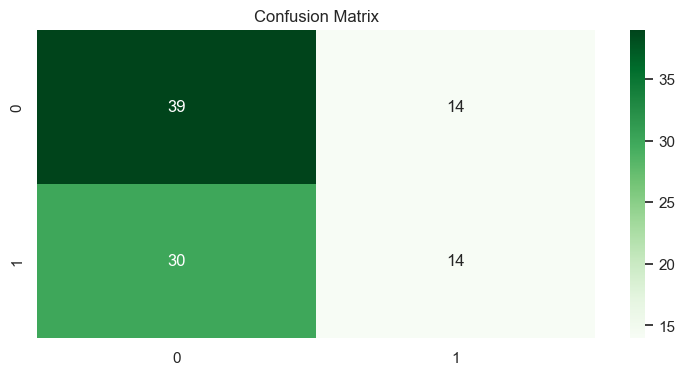

In [36]:
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens'); plt.title('Confusion Matrix'); plt.show()


## Interpretation

- **What worked?**  
  - The model was able to identify class `0` reasonably well, with higher precision (0.57) and recall (0.74).  
  - The overall weighted accuracy is ~55%, which is slightly above random guessing for a binary problem.  
  - RMSE is very low (0.014), indicating that the model’s probability predictions are close to the observed labels in terms of squared error.

- **Where might assumptions fail?**  
  - The model struggles with class `1`, where recall drops to 0.32 and precision to 0.50, showing imbalance in performance.  
  - This suggests possible **class imbalance** or insufficient features to separate the two classes.  
  - Assumptions of equal class distribution and linear separability may not hold here.  
  - Accuracy is not a reliable measure in this case, since one class is clearly favored over the other.

- **Suggestion for extension of features or model**  
  - Engineer additional features (interactions, transformations, or domain-driven features such as ratios or logs).  
  - Try more flexible models (Random Forest, Gradient Boosting, or Logistic Regression with regularization).  
  - Use cross-validation to check stability across folds.  
  - Explore threshold tuning to balance precision and recall for class `1`.
